In [1]:
import torch

# Test indices saved properly

In [2]:
dataset = 'conceptual_captions'
layer_num = 11
neuron_num = 1
subtype = 'hook_mlp_out'
sampling_type = 'avg'
interval = 'top'
file_name = 'indices_and_activations.pt'
train_or_val = 'val'

file_path = f'/network/scratch/s/sonia.joseph/CLIP_AUDIT/sampled_images/open-clip_laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/{dataset}/{train_or_val}/all_neurons/layer_{layer_num}/neuron_{neuron_num}/{subtype}/{sampling_type}/{interval}/'

In [4]:
# open .pt file

indices_and_activations = torch.load(file_path + file_name)
indices_and_activations

{'indices': [12292,
  10745,
  11609,
  7787,
  766,
  4932,
  8243,
  8147,
  8764,
  8256,
  1915,
  2686,
  4123,
  4728,
  9023,
  5428,
  6836,
  8631,
  13134,
  1298],
 'activations': array([-0.02334716, -0.02231688, -0.01798657, -0.01566531, -0.01492957,
        -0.01263985, -0.00691715, -0.00589235, -0.00244319,  0.01127381,
         0.01153159,  0.01540076,  0.03846711,  0.04513085,  0.05568371,
         0.06516428,  0.08227505,  0.13344939,  0.16014372,  0.36231813],
       dtype=float32)}

In [7]:
from clip_audit.dataloader.conceptual_captions import load_conceptual_captions
from clip_audit.utils.load_imagenet import load_imagenet

if dataset == 'conceptual_captions':
    dataloader = load_conceptual_captions(train_or_val)
elif dataset == 'imagenet':
    path = '/network/scratch/s/sonia.joseph/datasets/kaggle_datasets'
    dataloader = load_imagenet(path, train_or_val, shuffle=False)

Loading validation dataset
Found 15840 annotations in TSV file
Successfully loaded image files from cache
Successfully loaded 13204 valid image-annotation pairs from cache


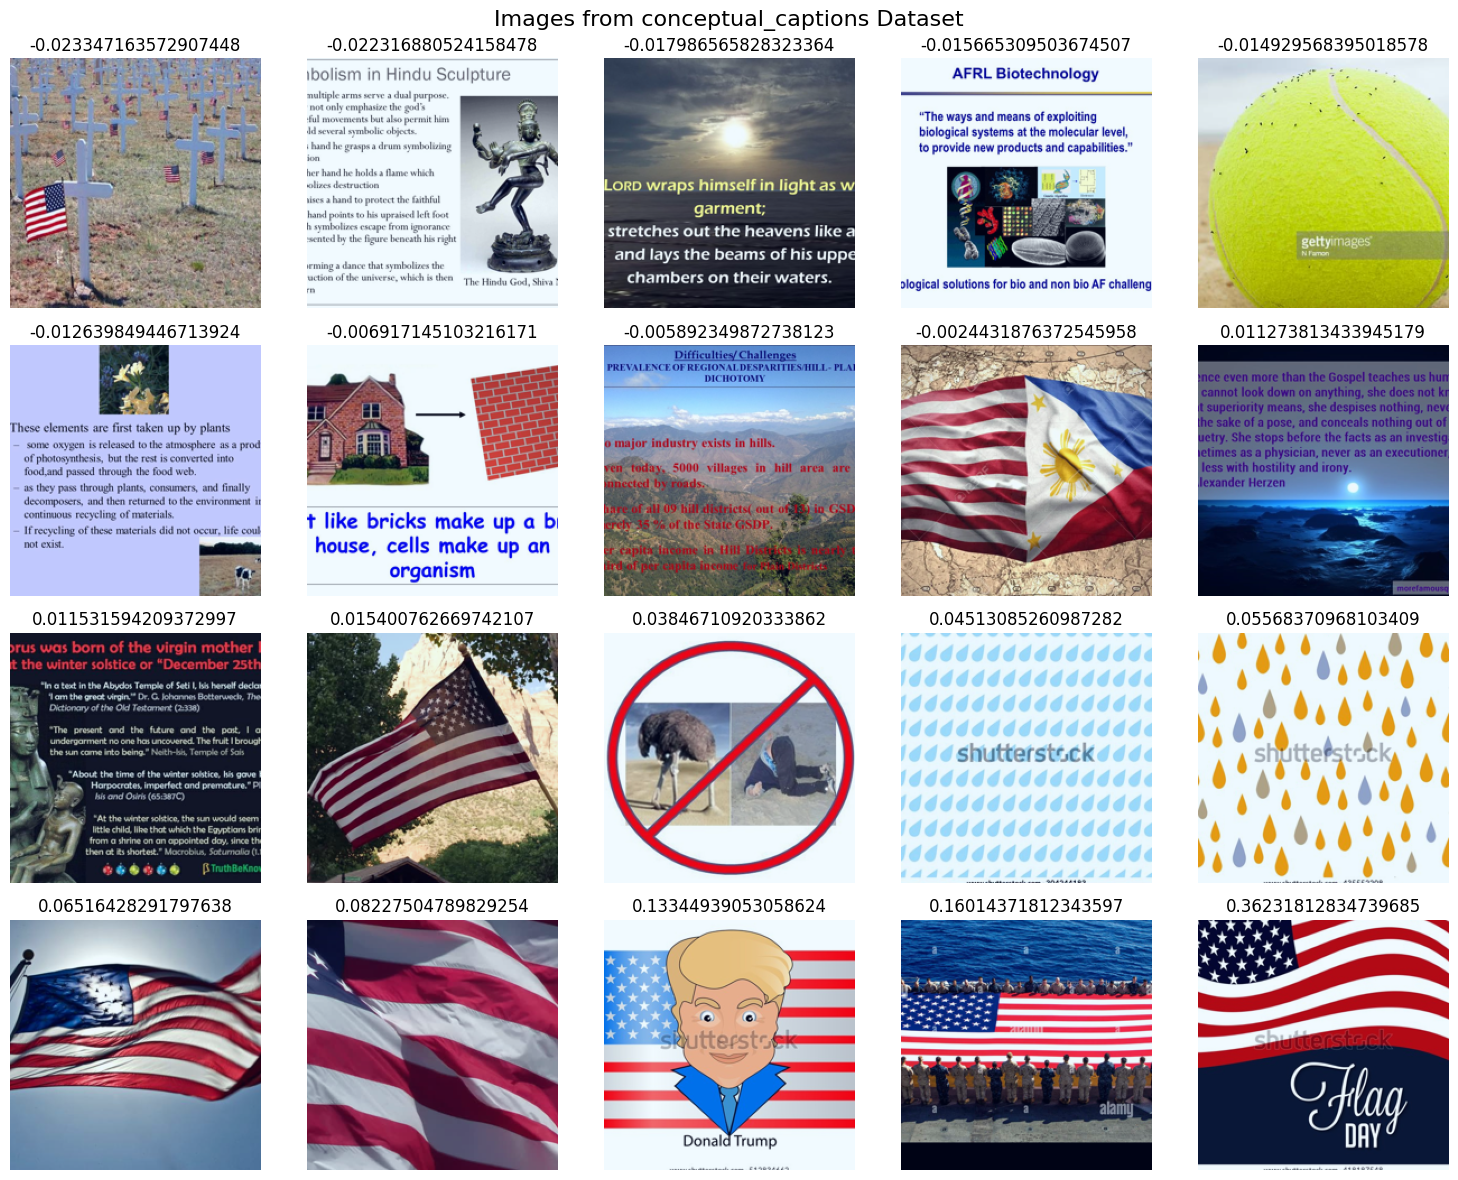

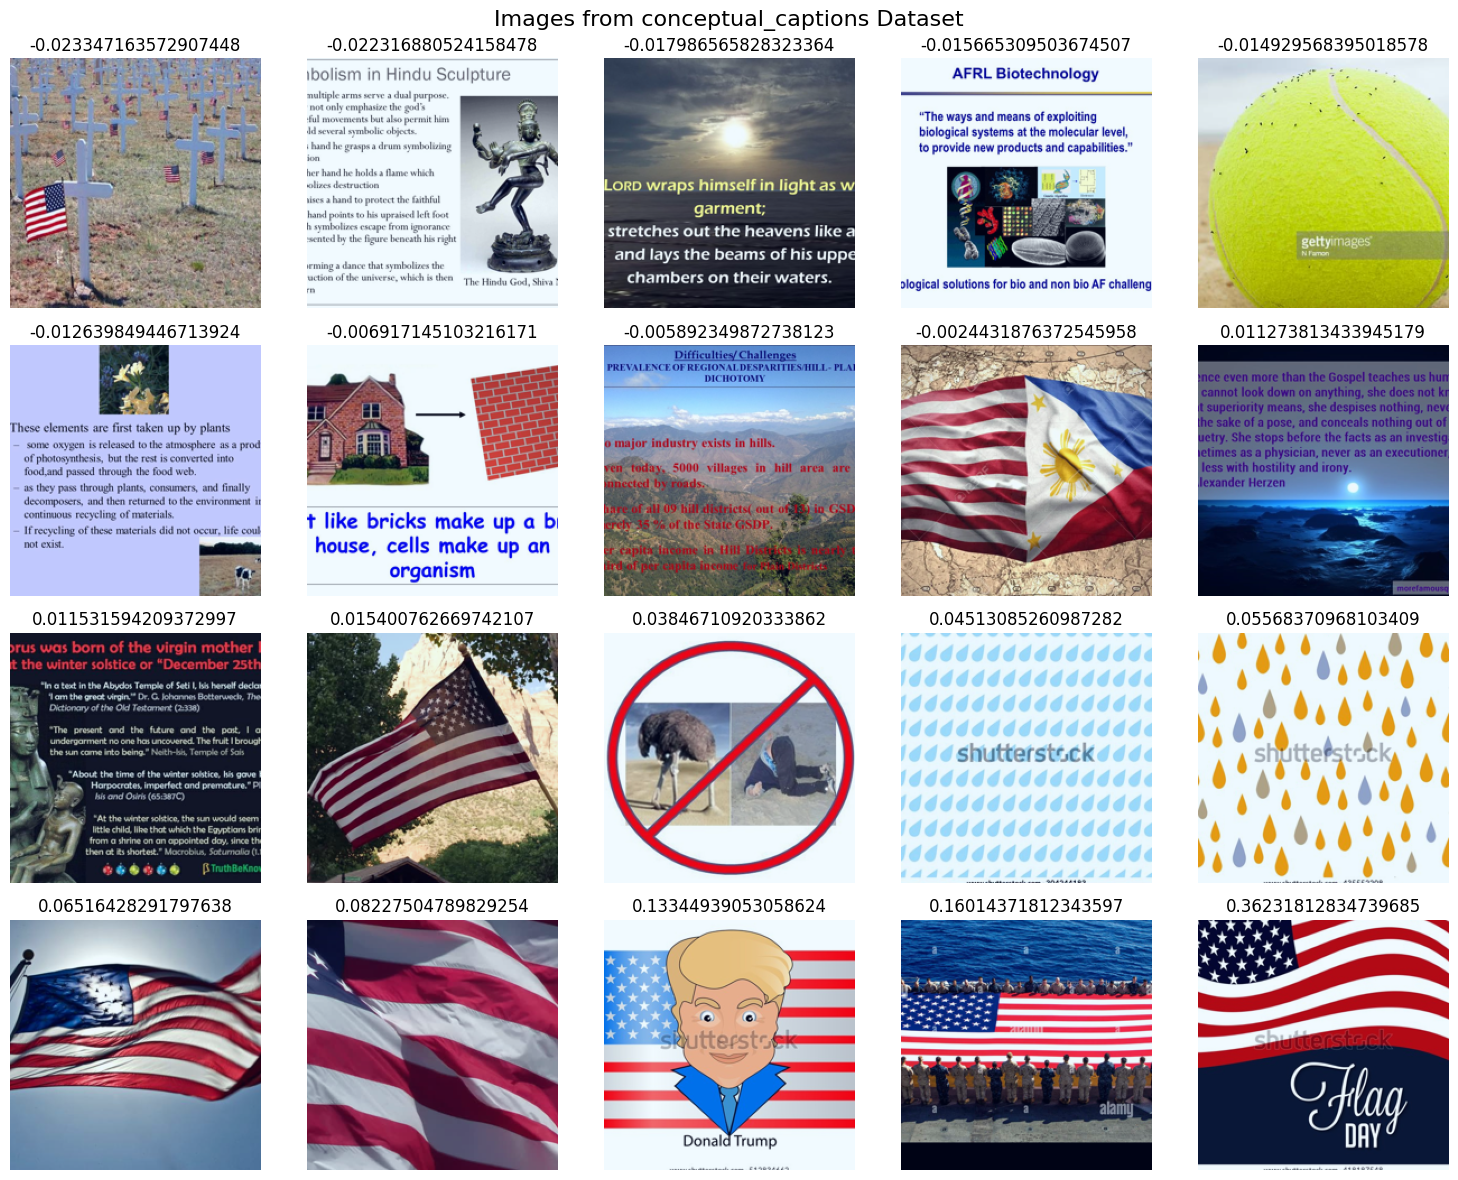

In [8]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image



def get_clip_val_transforms_display(image_size=224):
    """
    Transform for display that preserves the visual quality of the image
    """
    return transforms.Compose([
        transforms.Resize(size=image_size, interpolation=InterpolationMode.NEAREST),
        transforms.CenterCrop(size=(image_size, image_size)),
        # No need for ToTensor() and permute since we want to keep the image displayable
    ])

# Loop through 20 indices

def plot_images(activations, indices, dataloader):

    # Create a figure with 4x5 subplots
    fig, axes = plt.subplots(4, 5, figsize=(15, 12), facecolor='white')
    fig.suptitle(f'Images from {dataset} Dataset', fontsize=16)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    for i, (act, idx) in enumerate(zip(activations, indices)):
        # Get image tensor
        if dataset == 'conceptual_captions':
            image = dataloader.dataset[idx]['image']
            caption = dataloader.dataset[idx]['caption']
        elif dataset == 'imagenet':
            image = dataloader.dataset[idx][0]
            caption = None

        display_transform = get_clip_val_transforms_display()
        
        # img_pil = transforms.CenterCrop(224)(img_pil)
        if isinstance(image, Image.Image):
            display_image = display_transform(image)
        else:
            img = image.permute(1, 2, 0).numpy()
            display_image = (img - img.min()) / (img.max() - img.min())
        
        
        # Plot on corresponding subplot with white background
        axes[i].imshow(display_image)
        axes[i].axis('off')
        axes[i].set_title(f'{act}')
        axes[i].patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()
    return fig

plot_images(indices_and_activations['activations'], indices_and_activations['indices'], dataloader)

# Test CLIP index mapping is correct

In [9]:
# now confirm we can map neuron back to original neuron
import numpy as np
from clip_audit.dataloader.conceptual_captions import load_conceptual_captions

# clip_index_mapping = np.load('../saved_data/clip_base_mlp_out.npy', allow_pickle=True).item()
print("Subtype is ", subtype)
if subtype =='hook_resid_post':
    clip_index_mapping = np.load('../saved_data/clip_base_residual_post.npy', allow_pickle=True).item()
elif subtype == 'hook_mlp_out':
    clip_index_mapping = np.load('../saved_data/clip_base_mlp_out.npy', allow_pickle=True).item()

print(clip_index_mapping)

Subtype is  hook_mlp_out
OrderedDict([(0, array([571, 503, 723, 377,  40, 622, 660, 361, 272, 532, 732, 246, 437,
        72, 334, 289, 651, 204,  64, 191, 218, 699, 464, 663, 415, 385,
       517, 548, 243, 387])), (1, array([662, 367, 684, 118, 592, 695,  42, 295, 280,  73, 131, 212, 640,
       206, 277, 651, 702, 685, 161, 198, 156, 565, 495, 623, 716, 491,
       407,  60, 391, 487])), (2, array([ 13, 375, 585, 122, 762,  50, 425, 734, 202, 468,  21, 303, 639,
       320, 333, 446, 342, 195, 485, 642, 740, 252,  24, 354, 723, 359,
       724,  68, 207, 751])), (3, array([131, 557, 476, 548, 550, 395, 754, 455, 458, 756, 406, 537, 117,
       663, 159, 628, 486, 640, 553, 351, 446, 105, 654, 344,  18, 198,
       331, 590, 532, 208])), (4, array([435,  47, 650, 518,  15, 482, 417, 161, 500, 735, 623, 101, 299,
       516, 465, 664,  21, 523, 183, 758, 633, 537, 201, 215, 490, 550,
       760, 660,  98, 723])), (5, array([496, 227, 504, 753,  86, 523,  73, 733, 320, 553, 349, 109,  

In [10]:
def get_neuron_idx(layer_idx, neuron_num, neuron_dict):
    """
    Maps layer index and neuron number to the actual neuron index.
    
    Args:
        layer_idx (int): The layer index (key in the OrderedDict)
        neuron_num (int): Number from 0 to 29
        neuron_dict (OrderedDict): The dictionary mapping layers to neuron indices
    
    Returns:
        int: The actual neuron index
        
    Raises:
        ValueError: If neuron_num is not between 0 and 29
        KeyError: If layer_idx is not in the dictionary
    """
    if not 0 <= neuron_num <= 29:
        raise ValueError("neuron_num must be between 0 and 29")
    
    if layer_idx not in neuron_dict:
        raise KeyError(f"layer_idx {layer_idx} not found in dictionary")
    
    return neuron_dict[layer_idx][neuron_num]


print(f"Getting old neuron index fo layer {layer_num} and neuron {neuron_num} for {subtype}")
old_neuron_num = get_neuron_idx(layer_num, neuron_num, clip_index_mapping)
print("Old neuron num:", old_neuron_num)

Getting old neuron index fo layer 11 and neuron 1 for hook_mlp_out
Old neuron num: 627


In [11]:
# Now let's check CLIP with the validation to see if this is indeed the case
from vit_prisma.models.base_vit import HookedViT

model_name = 'open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K'

model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True, fold_ln=False, center_writing_weights=False) # in future, do all models


model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


In [62]:
# if dataset == 'conceptual_captions':
#     val_dataloader = load_conceptual_captions('val')
# elif dataset =='imagenet':
#     from vit_prisma.transforms.open_clip_transforms import get_clip_val_transforms 
#     full_transform = get_clip_val_transforms()
#     val_dataloader = load_imagenet(path, 'val', shuffle=False, transform = full_transform, batch_size=256)

# output = next(iter(val_dataloader))

In [17]:
# Track top activations
cache_key = f'blocks.{layer_num}.{subtype}'
print(cache_key)

top_k_activations = []
top_k_indices = []
k = 20  # Define k

for idx, sample in enumerate(dataloader):

    if dataset == 'imagenet':
        image = sample[0]
        caption = None
    elif dataset == 'conceptual_captions':
        image = sample['image']
    
    _, cache = model.run_with_cache(image, names_filter=[cache_key])
    activations = cache[cache_key]
    activations = activations[:,:,old_neuron_num]
    mean_activations = activations.mean(dim=1)
    
    # Get max activation
    max_act = mean_activations.max()
    max_idx = mean_activations.argmax()

    # Turn into global index
    global_idx = idx * dataloader.batch_size + max_idx

    # Get top k activations
    if len(top_k_activations) < k:
        top_k_activations.append(max_act)
        top_k_indices.append(global_idx)
    else:
        # Combine current lists with new values
        combined_activations = torch.tensor(top_k_activations + [max_act])
        combined_indices = torch.tensor(top_k_indices + [global_idx])
        
        # Get top k values and indices
        top_k_values, top_k_idx = torch.topk(combined_activations, k)
        
        # Update the lists
        top_k_activations = top_k_values.tolist()
        top_k_indices = combined_indices[top_k_idx].tolist()

    # print(f"Current top {k} activations: {top_k_activations}")
    # print(f"Current top {k} indices: {top_k_indices}")



blocks.11.hook_mlp_out


/home/mila/s/sonia.joseph/env/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/home/mila/s/sonia.joseph/env/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [67]:
# # Track top activations
# from tqdm.notebook import tqdm

# cache_key = f'blocks.{layer_num}.{subtype}'
# print(cache_key)

# max_batches = len(val_dataloader)
# count = 0

# top_k_activations = []
# top_k_indices = []
# k = 20  # Define k

# for idx, sample in tqdm(enumerate(val_dataloader), total=max_batches):
#     if dataset == 'imagenet':
#         image = sample[0]
#         caption = None
    
#     _, cache = model.run_with_cache(image, names_filter=[cache_key])
#     activations = cache[cache_key]
#     activations = activations[:,:,old_neuron_num]
#     mean_activations = activations.mean(dim=1)
    
#     # For each sample in the batch
#     for batch_idx in range(mean_activations.shape[0]):
#         act_value = mean_activations[batch_idx].item()
#         global_idx = idx * val_dataloader.batch_size + batch_idx
        
#         # Get top k activations
#         if len(top_k_activations) < k:
#             top_k_activations.append(act_value)
#             top_k_indices.append(global_idx)
#             # Sort if we have k elements
#             if len(top_k_activations) == k:
#                 # Sort in descending order
#                 sorted_pairs = sorted(zip(top_k_activations, top_k_indices), reverse=True)
#                 top_k_activations, top_k_indices = zip(*sorted_pairs)
#                 top_k_activations = list(top_k_activations)
#                 top_k_indices = list(top_k_indices)
#         elif act_value > top_k_activations[-1]:  # If current activation is larger than smallest in top k
#             top_k_activations[-1] = act_value
#             top_k_indices[-1] = global_idx
#             # Re-sort the lists
#             sorted_pairs = sorted(zip(top_k_activations, top_k_indices), reverse=True)
#             top_k_activations, top_k_indices = zip(*sorted_pairs)
#             top_k_activations = list(top_k_activations)
#             top_k_indices = list(top_k_indices)
    
#     count += 1
#     if count >= max_batches:
#         break
#     if (idx + 1) % 100 == 0:  # Print progress every 100 batches
#         print(f"Processed {idx + 1} batches")
#         print(f"Current top {k} activations: {top_k_activations[:5]}...")
#         print(f"Current top {k} indices: {top_k_indices[:5]}...")

# # Final results
# print("\nFinal Results:")
# print(f"Top {k} activations: {top_k_activations}")
# print(f"Top {k} indices: {top_k_indices}")

blocks.11.hook_mlp_out


  0%|          | 0/195 [00:00<?, ?it/s]

Processed 100 batches
Current top 20 activations: [0.1311197131872177, 0.07744047045707703, 0.014409475028514862, 0.007095426321029663, 0.004748730454593897]...
Current top 20 indices: [14372, 12500, 2797, 24406, 25191]...


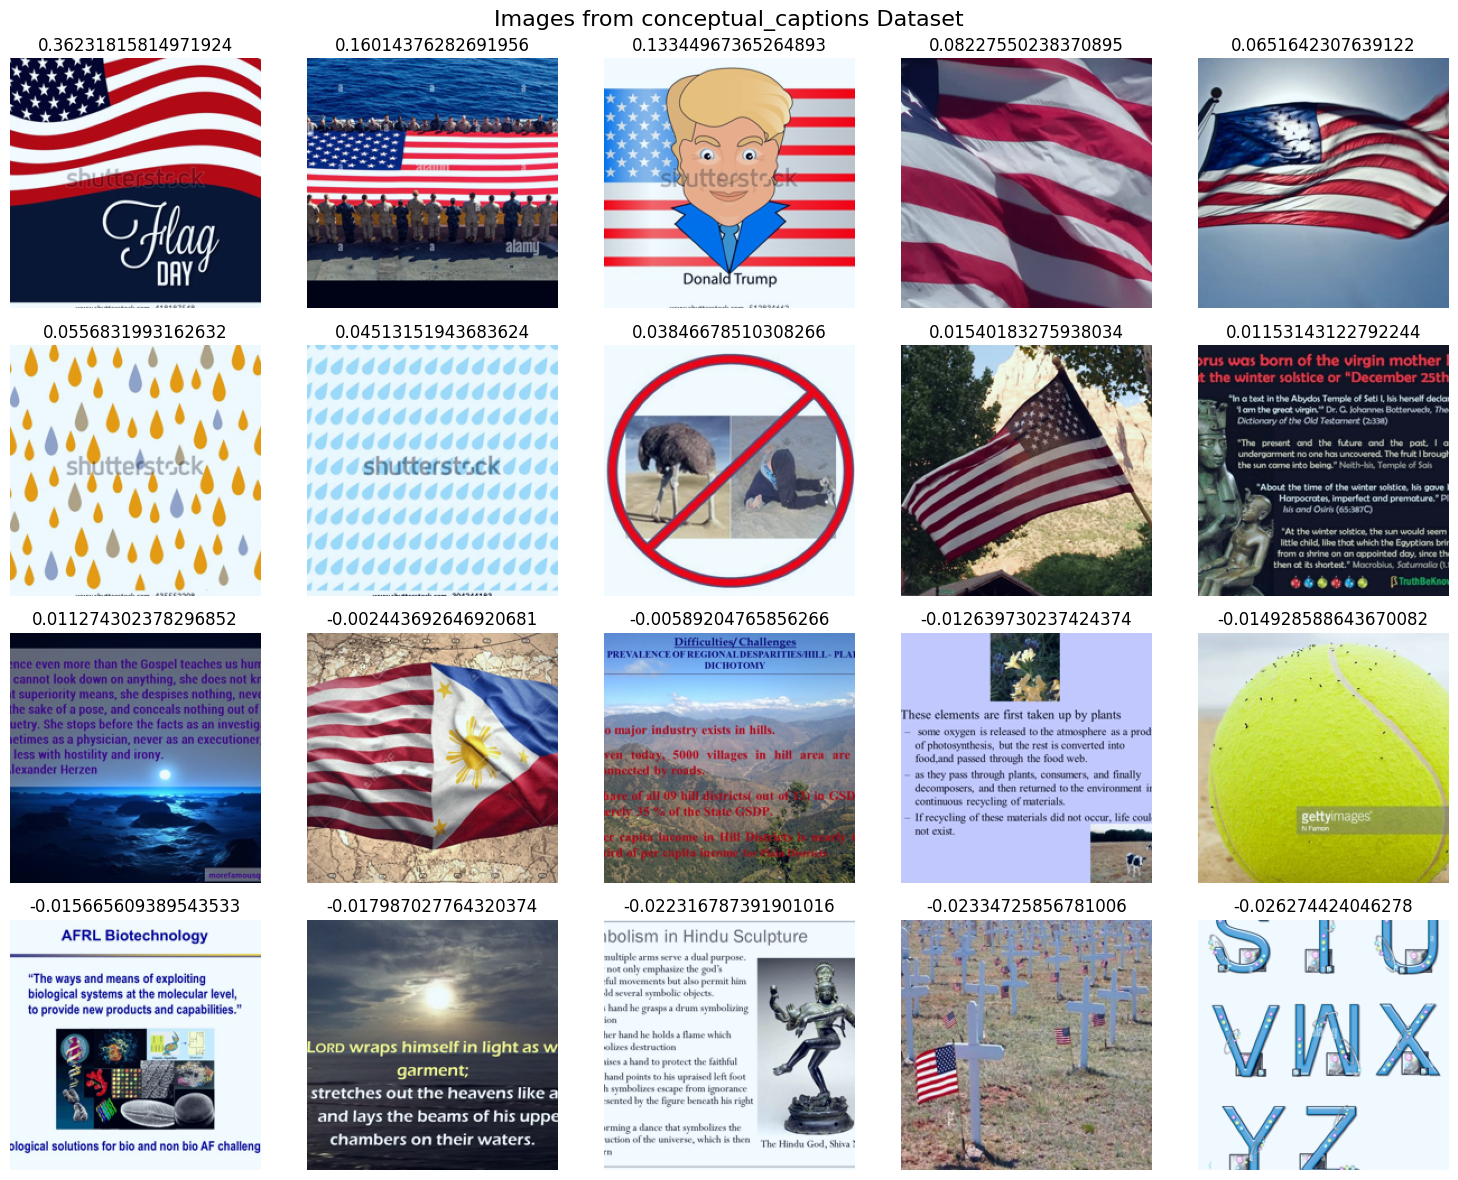

In [18]:
# top_indices = [idx for _, idx in top_act_and_idx]
# top_activations = [act for act, _ in top_act_and_idx]

fig = plot_images(top_k_activations, top_k_indices, dataloader)